In [1]:

###############
# 1. import
#####

import pandas as pd
from datetime import datetime, timedelta
import re
import time 

# local only
import os
import cx_Oracle as oci
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)


In [3]:

# # DB접속 : 폴 바셋
# con_text = open("C:/Users/MAEIL/conn_MCRM.txt", 'r', encoding='utf8')
# con_text = con_text.read()


# # DB접속 : 셀렉스몰
# con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
# con_text = con_text.read()


In [2]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 통합멤버십
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

In [4]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 통합멤버십
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

query = '''
        select trim(I.sef_cert_CI) as CI
        , I.mmb_id as ID 
        , I.mmb_nm as NAME
        , to_char(sysdate, 'YYYY')-substr(I.btdy,1,4) as Age
        , (case when I.GNDR_DV_CD in( '2','4') then 'F' else 'M' end) as gender
        , I.wrls_tel_no1 || I.wrls_tel_no2 || I.wrls_tel_no3 as cellno
        , I.reg_dtm
        , round(sysdate - I.reg_dtm, 0) as time_lag
        , trim(AD.rozip_base_addr) as addr
        , substr(trim(AD.rozip_base_addr),1,2) as addr_lv1
        from mmbship.tm_mmb_info I, mmbship.tm_mmb_addr AD, mmbship.tm_stpl_agrm A, mmbship.tm_mktg_recv_agrm M
        where I.mmb_st_cd = '1'
        and I.mmb_id is not null
        AND I.stff_dv_cd <> '1'
        and to_char(sysdate, 'YYYY')-substr(I.btdy,1,4) between 30 and 49
        and I.reg_dtm between sysdate-40 and sysdate
        and I.GNDR_DV_CD in( '2','4')
        and I.unfy_mmb_no = AD.unfy_mmb_no (+) 
        and (trim(AD.rozip_base_addr) like '서울%' or trim(AD.rozip_base_addr) like '경기%' or trim(AD.rozip_base_addr) like '인천%') --주소정보
        and I.unfy_mmb_no = A.unfy_mmb_no 
        and A.coopco_cd = '7010' and A.agrm_yn = 'Y'    --메일아이 제3자 동의
        and I.unfy_mmb_no = M.unfy_mmb_no 
        and M.coopco_Cd  = '7010' and m.sms_recv_dv_cd = 1
        '''

df_maeili = pd.read_sql(query, con = conn )


In [5]:
df_maeili.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   CI        588 non-null    object        
 1   ID        588 non-null    object        
 2   NAME      588 non-null    object        
 3   AGE       588 non-null    int64         
 4   GENDER    588 non-null    object        
 5   CELLNO    588 non-null    object        
 6   REG_DTM   588 non-null    datetime64[ns]
 7   TIME_LAG  588 non-null    int64         
 8   ADDR      588 non-null    object        
 9   ADDR_LV1  588 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 46.1+ KB


In [6]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 셀렉스
con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

###############
# 2.데이터 정렬
#####
query = '''
        select trim(I.CI) as CI
        , I.login_id as ID
        , I.name
        , to_char(sysdate, 'YYYY')-to_char(I.birth, 'YYYY') as AGE
        , I.phone_number as cellno
        , (case when U.sex in( 'W','w') then 'F' else 'M' end) as gender
        , U.REG_DATE as reg_dtm
        , round(sysdate - U.REG_DATE, 0) as time_lag
        , U.address as ADDR
        , substr(trim(u.address),1,2) as addr_lv1
        from selexfit.user_ I, userinfo U
        where I.login_id = U.id
        and I.ci is not null
        and U.sms_receive = 'Y'
        and U.sex = 'W'
        and GROUP_NAME = '일반'
        and (U.address like '%서울%' or U.address like '%경기%' or U.address like '%인천%')
        and to_char(sysdate, 'YYYY')-to_char(I.birth, 'YYYY') between 30 and 49
        and  U.REG_DATE between sysdate-40 and sysdate
        '''

df_selex = pd.read_sql(query, con = conn )


In [7]:
df_selex['GUBUN'] ='셀렉스몰'
df_maeili['GUBUN'] ='매일아이'

In [8]:
df = pd.concat([df_maeili, df_selex ], ignore_index= True)

In [9]:
len(df)

1271

In [10]:
df2 = df.drop_duplicates(subset= 'CI')

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 0 to 1270
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   CI        1271 non-null   object        
 1   ID        1271 non-null   object        
 2   NAME      1271 non-null   object        
 3   AGE       1271 non-null   int64         
 4   GENDER    1271 non-null   object        
 5   CELLNO    1271 non-null   object        
 6   REG_DTM   1271 non-null   datetime64[ns]
 7   TIME_LAG  1271 non-null   int64         
 8   ADDR      1271 non-null   object        
 9   ADDR_LV1  1271 non-null   object        
 10  GUBUN     1271 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 119.2+ KB


In [12]:
df2.REG_DTM.min()

Timestamp('2022-04-02 10:28:15')

In [13]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 폴 바셋
con_text = open("C:/Users/MAEIL/conn_MCRM.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')


In [14]:
###############
# 2.데이터 정렬
#####
query = '''
        select trim(mobile_ci) as CI, cust_id
        from c_cust
        where mobile_ci is not null
        and cust_stat not in ('8', '9')
        and cash_use_dt is null
        and sav_cash = 0
        '''

df_pbs = pd.read_sql(query, con = conn )


In [15]:
df3 = pd.merge(df2, df_pbs, on='CI', how='left')

In [1]:
# df3.dropna()

In [17]:
# Excel 다운로드
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_PBS_targetting_rawdata.xlsx'
df3.to_excel(excel_name, sheet_name= 'Sheet1' )

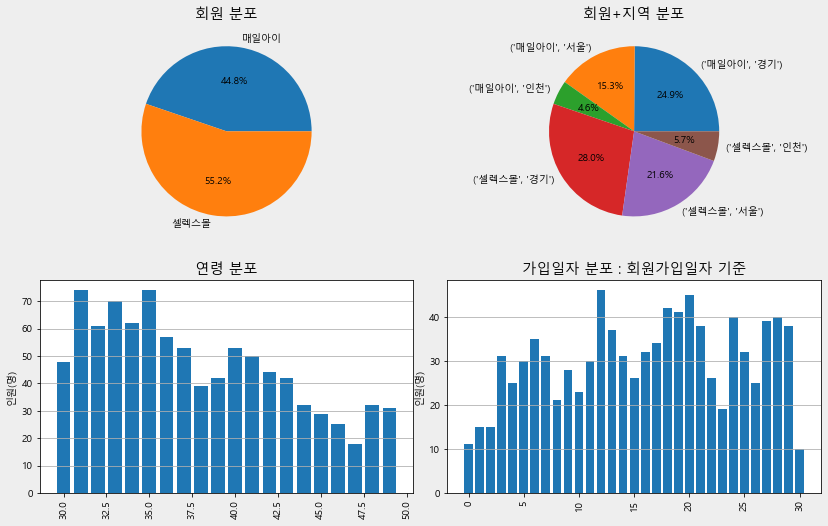

In [23]:
fig = plt.figure(figsize=(14, 18), facecolor='#eeeeee' )

# 그래프1 : 채널별 

ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
plt.pie(df2.groupby(['GUBUN', ])['CI'].count(), 
        labels=df2.groupby(['GUBUN', ])['CI'].count().index, autopct='%.1f%%')
# plt.legend(, loc="lower")
plt.title('회원 분포',fontsize='x-large')

ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2)
plt.pie(df2.groupby(['GUBUN', 'ADDR_LV1'])['CI'].count(), 
        labels=df2.groupby(['GUBUN', 'ADDR_LV1'])['CI'].count().index, autopct='%.1f%%')
# plt.legend(, loc="lower")
plt.title('회원+지역 분포',fontsize='x-large')


# 그래프1 : 채널별 
ax3 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.bar(list(df2.AGE.value_counts().sort_index().index), list(df2.AGE.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('연령 분포',fontsize='x-large')
plt.ylabel('인원(명)')

ax4 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.bar(list(df2.TIME_LAG.value_counts().sort_index().index), list(df2.TIME_LAG.value_counts().sort_index()))
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('가입일자 분포 : 회원가입일자 기준',fontsize='x-large')
plt.ylabel('인원(명)')

plt.show()